### BME 671L SPAM, Fall 2022
## Final Project - EEG Sleep Analysis
#### Authors: Braden Garrison, Jerry Yang, Trevor Alston


## Project Description:

The aim of this project is to construct an algorithm that will take in raw sleep EEG data as an input, clean up and transform the data, and quantify the amount of time spent in each specific cycle of sleep. This is a signficant task because sleep analysis is used to gauge quality of sleep depending on the number of hours spent in certain sleep stages. We plan to clean the raw EEG data using certain filtering techniques explored in lab, and we will identify specific sleep stage signals based on their dominant frequency ranges.

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from scipy import signal, misc

## Data Acquisition and Read-In

In [2]:
data = mne.io.read_raw_edf("data/n1.edf")
data.info

Extracting EDF parameters from C:\Users\brade\Documents\School\College\Grad School\Duke\BME 671L SPAM\BME671-Final-Project\data\n1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


<Info | 7 non-empty values
 bads: []
 ch_names: ROC-LOC, LOC-ROC, F2-F4, F4-C4, C4-P4, P4-O2, F1-F3, F3-C3, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.3 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-01-01 22:06:03 UTC
 nchan: 21
 projs: []
 sfreq: 512.0 Hz
>

In [5]:
data.ch_names

['ROC-LOC',
 'LOC-ROC',
 'F2-F4',
 'F4-C4',
 'C4-P4',
 'P4-O2',
 'F1-F3',
 'F3-C3',
 'C3-P3',
 'P3-O1',
 'C4-A1',
 'EMG1-EMG2',
 'ECG1-ECG2',
 'TERMISTORE',
 'TORACE',
 'ADDOME',
 'Dx1-DX2',
 'SX1-SX2',
 'Posizione',
 'HR',
 'SpO2']

> At least 3 EEG: F3 or F4, C3 or C4 and O1 or O2, referred to A1 or A2

> Additional EEG bipolar traces: Fp1-F3, F3-C3, C3-P3, P3-O1 and/or Fp2-F4, F4-C4, C4-P4, P4-O2

In [3]:
raw_data = data.get_data()

In [4]:
fs = 512 #Hz
dt = 1/fs
t = np.arange(0, raw_data.shape[1]*dt, dt)

## EEG Channel Visualizations

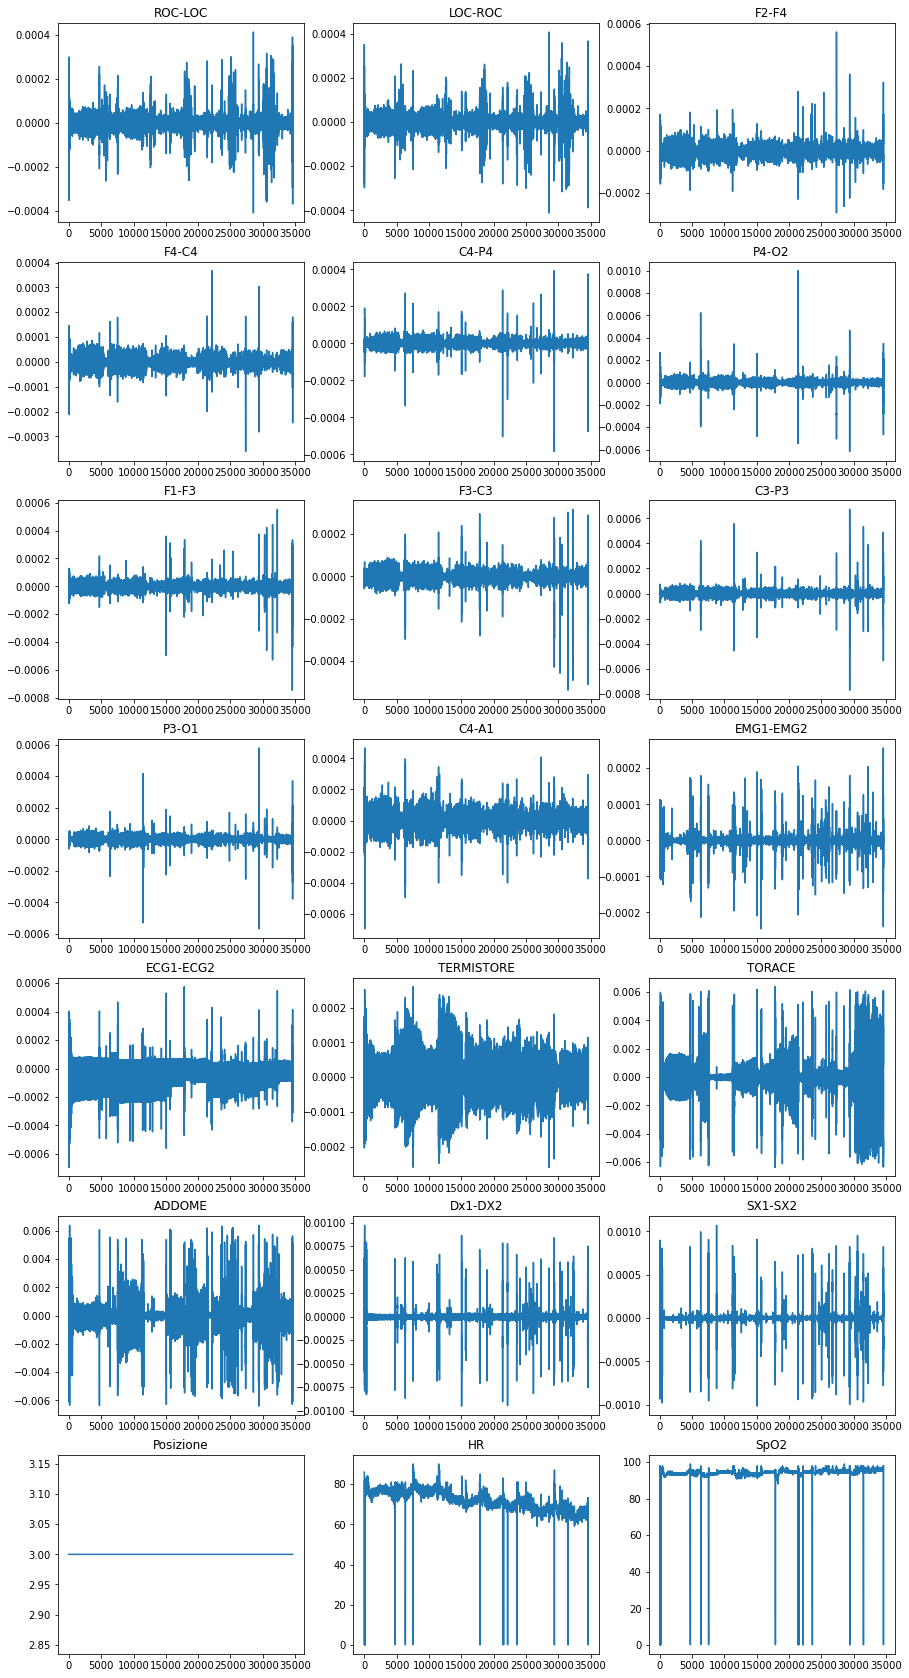

In [8]:
fig, ax = plt.subplots(7,3, figsize = (15,30))
for i in range(21):
    ax[i//3, i%3].plot(t, raw_data[i])
    ax[i//3, i%3].set_title(data.ch_names[i])

ROC-LOC was the channel used by the authors of the referenced research to identify sleep stages. ROC-LOC refers to "Right Outer Cantheus"-"Left Outher Cantheus", common EEG electrode placements placed 1 cm above or below the outer cantheus of the eye. These are common reference electrodes in standard EEGs and are often referred to as channels A1 and A2. We will be using the signal acquired from ROC in reference to LOC (i.e., ROC-LOC) to perform our sleep stage analysis to allow for proper comparison to the sleep stages provided by the researchers. We will base our sleep stage analysis on the frequency content of the EEG signal in approximately 30 second windows, similar to the approach taken by the authors of the datasets.

## Identifying Frequency Content
The Fourier Transform function from Lab 10 will be used to obtain the FT of our signal. Since this signal was acquired over approximately 10 hours, we will only be considering the first quarter of the signal. We will then plot this signal over a bandwidth of 30 Hz since the data was preprocessed using a BPF from 0.3-30 Hz.

In [5]:
# FT Function from Lab 10

def ExploreFTplots(hn, zeropad, FS):
    '''
    Inputs:
    hn: 1D input signal
    zeropad: number of zero padding to the right side of hn
    FS: sampling frequency in Hz
    
    fvec - > 1D Vector specify the frequency domain
    FTOutput - > Fourier Transform result with DC centered in the middle of the array
    
    '''
    # do padding
    zeropaddedhn = np.pad(hn, zeropad)
    
    # construct fvec with given function inputs
    fvec= np.linspace(-FS/2, FS/2, len(zeropaddedhn))
    
    # compute the fft result
    fft_result = np.fft.fft(zeropaddedhn)
    
    # perform the fft shift so that DC is centered in the resulting array
    FTOutput = np.fft.fftshift(fft_result)

    return fvec, FTOutput

# FT plotting function
def FTplot(fvec, FT):
    ft_mag = np.abs(FT)
    fvec_size = np.round(np.max(fvec), 0)
    plt.plot(fvec, ft_mag)
    plt.title('ROC-LOC FFT - {} Hz'.format(fvec_size))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.show()

(4431360,)


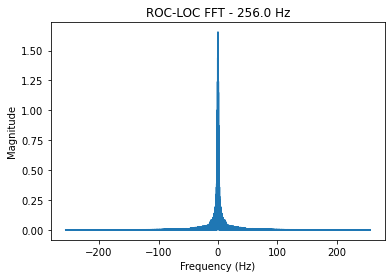

In [6]:
# Look at main EEG trace used to obtain provided sleep stages: ROC-LOC
eeg_signal = data['ROC-LOC'][0][0]
eeg_signalhalf = eeg_signal[0:round(len(eeg_signal)/4)]
print(eeg_signalhalf.shape)
fvec, eeg_FT = ExploreFTplots(eeg_signalhalf, 0, fs)
FTplot(fvec, eeg_FT)

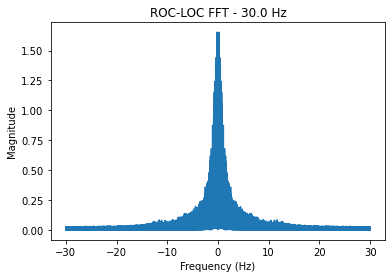

In [7]:
df = pd.DataFrame(data = {'fvec': fvec, 'FT': eeg_FT})
df_new = df[(abs(df['fvec']) <= 30)]

FTplot(df_new['fvec'].values, df_new['FT'].values)

### EEG Spectrogram
To visualize the frequency content of our signal in time, we will take the STFT and display a spectrogram. A window size of 30 seconds (i.e., nperseg = 512 (sampling freq) * 30 (desired time window in seconds)) will be used first since the control sleep stages were identified in 30 second intervals.

Zxx.shape: (7681, 578)


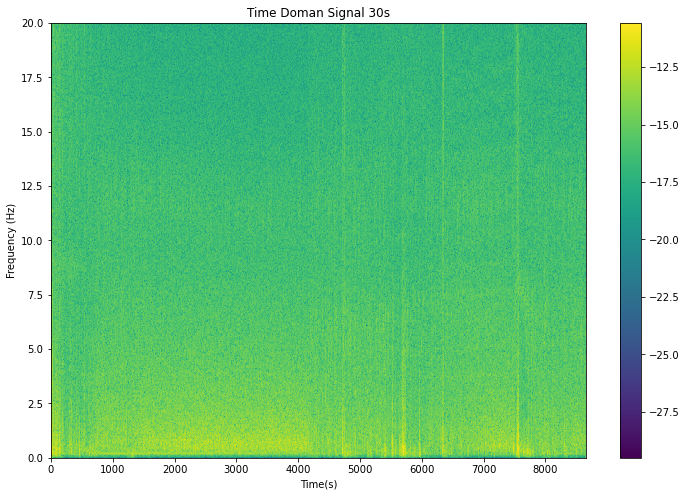

In [8]:
# STFT of our EEG data using 30 sec windows to match PhysioNet data windows
fs = 512
duration = 30
nperseg = fs*duration
f, t, Zxx = signal.stft(eeg_signalhalf, fs, nperseg=nperseg, nfft=None)
print('Zxx.shape:', Zxx.shape)

plt.rcParams['figure.figsize'] = [12,8]
plt.pcolormesh(t, f, np.log(abs(Zxx)))
plt.title('Time Domain Signal {}s'.format(duration));
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,20)
plt.colorbar()
plt.show()

While the frequency resolution of this spectrogram is great, the image is fuzzy due to poor time resolution. To address this, we will decrease the time window over which the STFT is taken to 1 second.

Zxx.shape: (257, 17311)


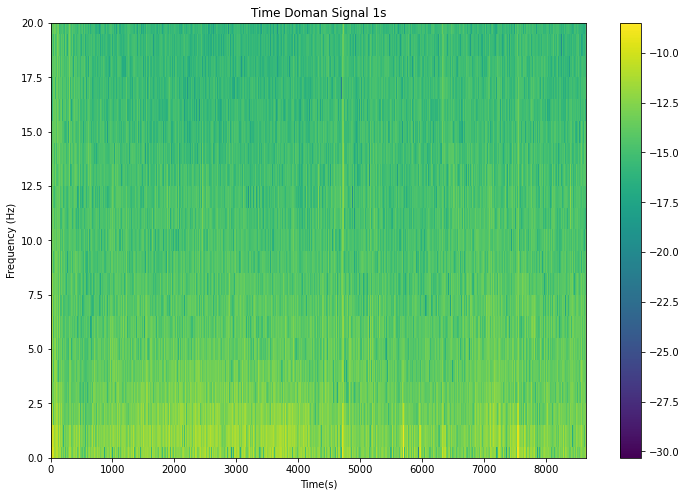

In [9]:
# STFT of our EEG data using smaller windows for better time resolution, sacrificing freq resolution
fs = 512
duration = 1
nperseg = fs*duration
f, t, Zxx = signal.stft(eeg_signalhalf, fs, nperseg=nperseg, nfft=None)
print('Zxx.shape:', Zxx.shape)

plt.rcParams['figure.figsize'] = [12,8]
plt.pcolormesh(t, f, np.log(abs(Zxx)))
plt.title('Time Domain Signal {}s'.format(duration));
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,20)
plt.colorbar()
plt.show()

The combination of these two plots provides a nice comprehensive picture of the frequency content of our signal over time. It is now necessary to quantify the frequency content over time to make sleep stage classification possible. 4 bandpass filters will be created and applied to our signal, one for every major brainwave frequency, to assess the magnitude of each brainwave in time. This data can be used to calculate the power of those bands in time which can be cross-referenced with literature to classify sleep stage.

C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\brade\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


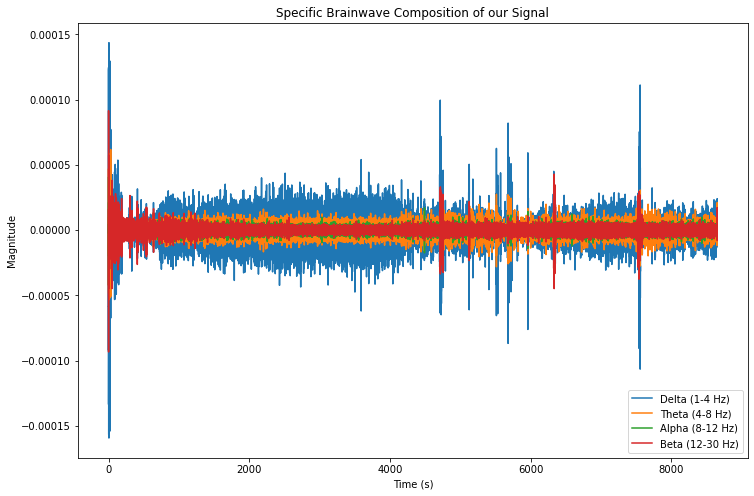

In [13]:
# Use BPF for each sleep stage freq range to calculate power in time
alpha_BPF = ((np.abs(fvec)<=12) & (np.abs(fvec)>=8))
delta_BPF = ((np.abs(fvec)<=4) & (np.abs(fvec)>=1))
theta_BPF = ((np.abs(fvec)<=8) & (np.abs(fvec)>=4))
beta_BPF = ((np.abs(fvec)<=30) & (np.abs(fvec)>=12))

alpha_FT = eeg_FT*alpha_BPF
alpha_time = np.fft.ifft(np.fft.fftshift(alpha_FT))

delta_FT = eeg_FT*delta_BPF
delta_time = np.fft.ifft(np.fft.fftshift(delta_FT))

theta_FT = eeg_FT*theta_BPF
theta_time = np.fft.ifft(np.fft.fftshift(theta_FT))

beta_FT = eeg_FT*beta_BPF
beta_time = np.fft.ifft(np.fft.fftshift(beta_FT))

t = np.arange(0, raw_data.shape[1]*dt/4, dt)
plt.plot(t, delta_time, label='Delta (1-4 Hz)')
plt.plot(t, theta_time, label='Theta (4-8 Hz)')
plt.plot(t, alpha_time, label='Alpha (8-12 Hz)')
plt.plot(t, beta_time, label='Beta (12-30 Hz)')
plt.title('Specific Brainwave Composition of our Signal')
plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

The power of each band across 30 second windows must be calculated to compare relative band powers and provide a sleep stage classification. Below, the power is found by taking the integral of each BPF signal over 30 second intervals. The signal will be much less fine due to the decrease in time specificity.

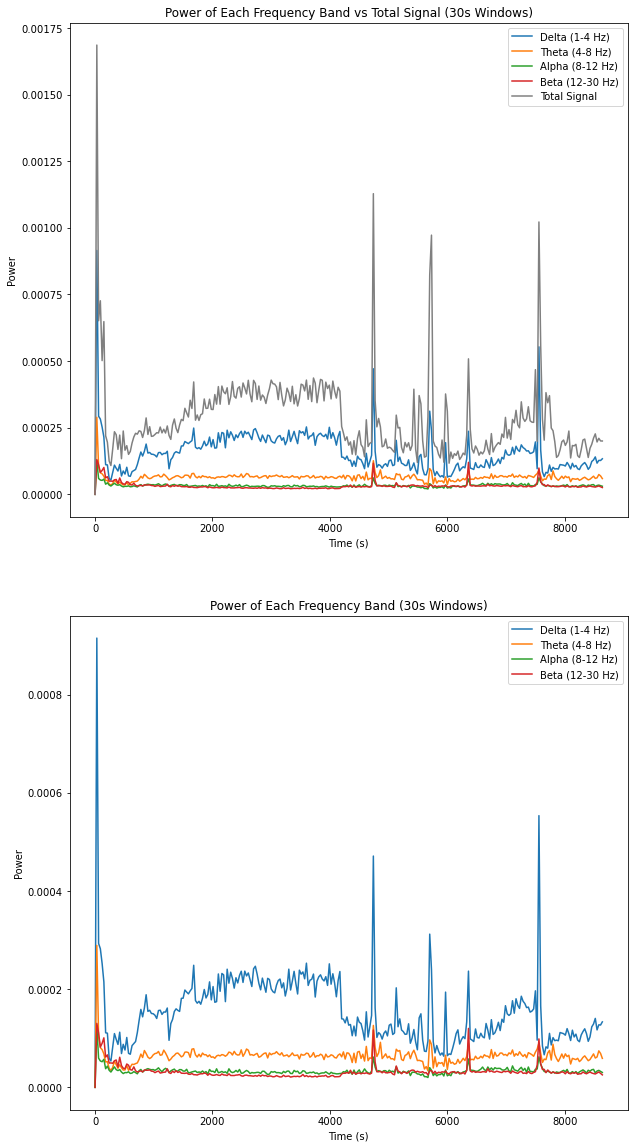

In [53]:
# Quantify power of each signal band in 30 sec windows
bins = np.arange(0, t[-1], 30)
tot_power, d_power, t_power, a_power, b_power = [0], [0], [0], [0], [0]
for i, val in enumerate(bins):
    if val == 0:
        continue
        
    total_sig = eeg_signalhalf[int(bins[i-1])*fs:int(val)*fs]
    total = np.sum(np.abs(total_sig))*dt
    tot_power.append(total)
    
    alpha_sig = alpha_time[int(bins[i-1])*fs:int(val)*fs]
    alpha = np.sum(np.abs(alpha_sig))*dt
    a_power.append(alpha)
    
    beta_sig = beta_time[int(bins[i-1])*fs:int(val)*fs]
    beta = np.sum(np.abs(beta_sig))*dt
    b_power.append(beta)
    
    delta_sig = delta_time[int(bins[i-1])*fs:int(val)*fs]
    delta = np.sum(np.abs(delta_sig))*dt
    d_power.append(delta)
    
    theta_sig = theta_time[int(bins[i-1])*fs:int(val)*fs]
    theta = np.sum(np.abs(theta_sig))*dt
    t_power.append(theta)
    
fig, ax = plt.subplots(2,1, figsize = (10,20))
ax[0].plot(bins, d_power, label='Delta (1-4 Hz)')
ax[0].plot(bins, t_power, label='Theta (4-8 Hz)')
ax[0].plot(bins, a_power, label='Alpha (8-12 Hz)')
ax[0].plot(bins, b_power, label='Beta (12-30 Hz)')
ax[0].plot(bins, tot_power, label='Total Signal', color='gray')
ax[0].set_title('Power of Each Frequency Band vs Total Signal (30s Windows)')
ax[0].legend()
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Power')

ax[1].plot(bins, d_power, label='Delta (1-4 Hz)')
ax[1].plot(bins, t_power, label='Theta (4-8 Hz)')
ax[1].plot(bins, a_power, label='Alpha (8-12 Hz)')
ax[1].plot(bins, b_power, label='Beta (12-30 Hz)')
ax[1].set_title('Power of Each Frequency Band (30s Windows)')
ax[1].legend()
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Power')
plt.show()


# Classify each window by which freq range dominates?
# Reference: https://assets.cdn.thewebconsole.com/S3WEB8659/images/Dr-Steven-Lin---the-five-stages-of-sleep-and-brain-wave-cycles.pdf
# Wakeful - 15-30 Hz (beta, <50 uV amplitude)
# S1 - 8-12 Hz (alpha, 50 uV)
# S2 - 4-8 Hz (theta, 50-100 uV)
# S3 - 4-15 Hz (theta, alpha, sigma, 50-150 uV)
# S4 - 1-4 Hz (delta, 100-200 uV)
# REM - 15-30 (<50 uv)
# NOTE: NEED TO MORE SPECIFICALLY DISTINGUISH BETWEEN WAKEFULNESS/REM AND S1-S3, possibly by identifying sleep spindles or k complexes
# NOTE: sleep spindles are 12-15 Hz (sigma band) and show up in S2


## Sleep Stage Classification
Now that we have obtained the relative powers of each frequency band, we can load in the sleep scoring data from the dataset to visualize what sleep stages we should expect to be classifying from this data.

In [30]:
# Compare our classification to the .txt doc classifications

# Load in .txt file of sleep stage classifications from PhysioNet
txt = open('n1.txt', 'r')
txt_data = txt.read()
txt.close()

# Create list of all sleep stage classifications for each time window (i.e., 30 sec)
txt_split = txt_data.split('\n') # Create list of values split by end of line
txt_split = txt_split[22:] # Get rid of all header information 

sleep_stage = []
for i, val in enumerate(txt_split): # Loop through lines of file left and extract only sleep stage classification - W, S1-S4, or R
    line_seg = val.split('\t')
    sleep_stage.append(line_seg[0])
    
if sleep_stage[-1] == '': # Get rid of last value if it is blank '' character
    sleep_stage.pop()

sleep_stage = sleep_stage[0:round(len(sleep_stage)/4)]
print(sleep_stage)
print(len(sleep_stage))

['W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'W', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S1', 'S2', 'S2', 'S2', 'S2', 'S2', 'S2', 'S2', 'S2', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S2', 'S2', 'S2', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S3', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S4', 'S

Now that we have our expected sleep classifications, we can begin to construct an algorithm to provide our own scoring based on the relative contributions of each frequency band across all 30 sec windows.

In [ ]:
# Quantify percent contribution of each frequency band to total signal across all 30 sec windows
percents = [[0], [0], [0], [0]] # Percent contributions of delta, theta, alpha, beta, respectively
for idx, val in tot_power:
    if idx == 0:
        continue
    
    percents[]